# Failures
Sometimes the model just doesn't work. I thought I would share my failed attempts too since they might be interesting as well. Almost always people will only publish what works but that is of course not reality!

# Privacy Survey

**Why this dataset probably failed**

There is simply not enough correlation between the answers to the other questions and the one we are trying to predict. The pair plot shows way to much overlap.

## Data
We will use a dataset from the Open Government Portal. In this case, it's the "2022-23 Survey of Canadians on privacy-related issues" based on phone interviews ([Source](https://open.canada.ca/data/en/dataset/897a64fd-619d-48cc-b056-c9f6484b63b1)).

Suppose we want to classify our respondents based on the answers they give. KNN could be a good algorithm for this since the answers to the questions would hopefully put people in neat boxes as all the questions are somewhat related to each other.

KNN is a supervised learning algorithm though which means it needs to have labels to learn from. One approach is to have a bunch of group members label a bunch of the surveys manually and then have the rest of the surveys be classified by the KNN algorithm. It's a lot less work than labelling them all manually.

However, we don't want to go into that. Instead we'll just use one of the questions as a label. One of the questions is "In general, are you concerned about the protection of your privacy?". We want to predict the answer to this question based on the answers to all of the other questions. This is still useful because if you can predict this question with near-100% accuracy, then you don't really need to include this question in subsequent survey and thus make it shorter and more likely for people to complete.

In [19]:
survey = pd.read_csv('2022-23_survey_canadians_dataset.csv')
survey

,QUEST,STYPE,LANG,QF,Q1,Q2,Q3A,Q3B,Q4A,Q4B,...,Q20M1,Q20M2,Q20M3,Q21,Q22,Q23,Q24,AGE_COL,REGION,WEIGHT
0,228,2,EN,6,4,7,2,2,,2,...,2,,,2,2,1,4,3,3,1.470245
1,349,2,FR,5,1,5,5,5,4,,...,2,,,2,2,1,7,3,2,0.853297
2,1019,2,EN,5,2,7,5,5,6,,...,1,,,2,99,99,7,2,2,1.578553
3,1109,2,FR,5,1,7,7,7,,7,...,2,,,2,2,1,7,3,2,0.853297
4,1208,2,EN,10,2,7,6,6,,5,...,1,,,2,99,2,3,3,5,1.068920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,263855,1,EN,2,1,3,3,1,2,,...,1,,,2,2,2,1,4,1,0.378720
1496,263883,1,EN,2,1,7,4,4,4,,...,1,,,2,2,99,4,3,1,0.811720
1497,263889,1,EN,2,2,6,5,3,4,,...,1,,,2,2,2,2,4,1,0.378720
1498,263926,1,EN,2,2,7,4,4,,6,...,1,,,2,2,2,6,4,1,0.378720


This is extremely cryptic data. Fortunately, there is a data dictionary that comes with this data set. The question we want to predict is Q2. The answers range from 1 to 7 but other options are 98 (don't know) and 99 (refused). Let's drop those 98 and 99 responses.

In [20]:
survey = survey[survey['Q2'] <= 7]

Let's corrolate this with the answers from a bunch of other questions, for example:

* 3A. How would you rate your knowledge of your privacy rights?
* 3B. How would you rate your knowledge of how to protect your privacy rights?
* 4A. How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.
* 4B. How much you agree or disagree with the following statements: I feel that the Government of Canada in general respects my privacy rights.
* 4C. How much you agree or disagree with the following statements: I am confident that I have enough information to know how new technologies might affect my personal privacy.
* 4D. Do you know what to do if you receive a notification from an organization about a privacy breach?

Looking closer at Q4A and Q4B by just looking at the table above, they seem to be mutually exclusive. Let's confirm that. Pandas lets you do boolean operations and with `sum` it will tell you the number of times `True` occurs.

In [21]:
sum((survey['Q4A'] != ' ') & (survey['Q4B'] != ' '))

0

So it looks like people got either question 4A or 4B but not both. The difference is that 4A asks about government and 4B asks about business. So what to do here?

We can merge them and assume people that people will trust governments and business in equal measure. Or we can create two separate data sets, one with government and one with business.

The one thing we cannot do is to just set it to zero because KNN will look at the nearest neighbours. This would just group people that didn't get 4A close to people that answered 1 on question 4B.

We'll go with the merging:

In [22]:
survey['Q4AB'] = (survey['Q4A'] + survey['Q4B']).astype('int')

/tmp/ipykernel_17375/2576484218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey['Q4AB'] = (survey['Q4A'] + survey['Q4B']).astype('int')


Let's get rid of the other "Don't know" and "Refused" answers

In [23]:
survey = survey[(survey['Q3A'] <= 7) & (survey['Q3B'] <= 7) & (survey['Q4AB'] <= 7) & (survey['Q4C'] <= 7) & (survey['Q4D'] <= 7)]

Let's look at the pairplot again to see if we can get similar patterns again that can be distinguished.

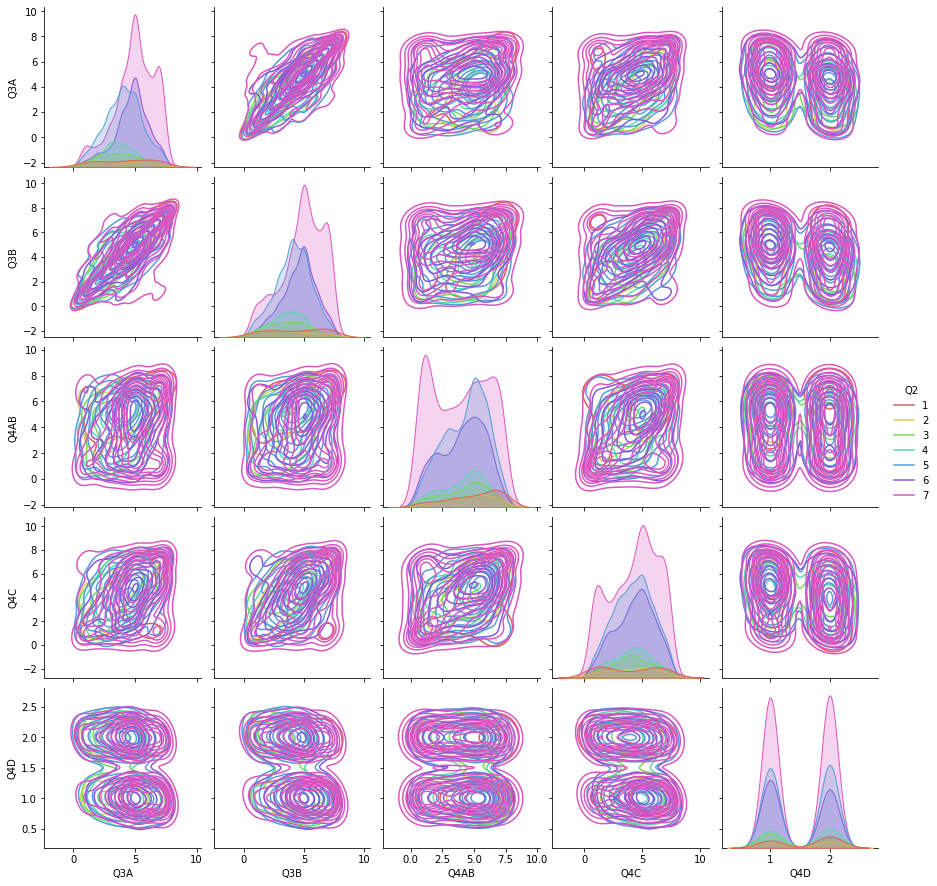

In [24]:
sns.pairplot(survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D', 'Q2']], hue='Q2', kind="kde", palette=sns.color_palette('hls',7))

Well, that does not look promising. There doesn't seem to be any relation. Just a tiny bit in Q3A and Q3B. Let's try it anyway and see what happens.

In [25]:
X = survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D']]
y = survey[['Q2']]

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

/tmp/ipykernel_17375/2542997030.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train, y_train)


0.36693548387096775

That is only a 33% accuracy which is not great! This tells us that the question "2. In general, are you concerned about the protection of your privacy?" does not really depend on the answers to the other questions that we picked.

In [26]:
X = survey[['Q3B']]
y = survey[['Q3A']]

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

/tmp/ipykernel_17375/1786791437.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train, y_train)


0.5080645161290323

# Book genres

**Why this dataset probably failed:**

This probably didn't work out because of the *curse of dimensionality* which says that if your input data has a very high number of dimensions (in this case a 74000 word input vector!) and a lot of those columns are actually mostly random, than that essentially guarantees that points will just be very far from each other even if some columns are relevant.

## Data
Use the CMU Book Summary Dataset at https://www.cs.cmu.edu/~dbamman/booksummaries.html

This dataset is tab separated without a header row. Column names comes from the accompying README.

In [2]:
books = pd.read_csv('booksummaries.txt', sep="\t", header=0, names=['wikipedia', 'freebase', 'title', 'author', 'publicationdate', 'genres', 'summary'])

In [3]:
# I don't feel like dealing with NaN
books = books.dropna()
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."


Genres are in a JSON format, so we will need the JSON package to extract those.

In [4]:
import json

Convert that JSON into a simple list. We don't care about the weird identifiers.

In [5]:
def genre(row):
    g = json.loads(row.genres)
    return list(g.values())

genresperbook = books.apply(genre, axis=1)
books = books.assign(genres=genresperbook)

In [6]:
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."


## Feature extraction
Unlike the penguins, we now want to predict multiple labels. One way we can do this is by creating a dummy column like we did for the islands before. Now we need a dummy column for each genre.

The following code does that. It's fairly dark magic and full transparency, I just copied it mostly from StackOverflow, but what it does is that it takes the lists in the genres column and converts them to a Pandas Series. Then it stacks them one on the other while keeping the main index but with a sub index for each genre per book. Then we get the dummies for that. The result of that is still a multi-index DataFrame but now with a column for every genre per book per listed genre for that book.

We need to collapse that back into a single-index DataFrame again, so we group all that by the first index of our multi-index DataFrame which is the index for the books. We sum on that which means that per book we now have a single row that has a 1 if that book is part of a certain genre and 0 if not. Then we add a prefix to the column name.

In [7]:
dummies = books.genres.apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('genre_')
books = books.join(dummies)

In [18]:
books

,wikipedia,freebase,title,author,publicationdate,genres,summary,genre_Absurdist fiction,genre_Adventure,genre_Adventure novel,...,genre_Utopian fiction,genre_Vampire fiction,genre_War novel,genre_Western,genre_Western fiction,genre_Whodunit,genre_Wuxia,genre_Young adult literature,genre_Zombie,genre_Zombies in popular culture
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...",0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16548,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16550,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16554,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16555,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,[Autobiography],The book follows very rough chronological ord...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Phew!! Now the data is in a form we can use for the labels.

Let's look a bit closer at the genres and in particular how many books we have in each category. We'll just sum the dummy columns for genres.

In [9]:
genreusage = books.drop(['wikipedia', 'freebase', 'author', 'publicationdate', 'genres', 'title', 'summary'], axis=1).sum().sort_values(ascending=False)
genreusage

genre_Fiction                3674
genre_Speculative fiction    3270
genre_Novel                  2088
genre_Science Fiction        2001
genre_Fantasy                1863
                             ... 
genre_Prose                     1
genre_Photography               1
genre_Indian chick lit          1
genre_Superhero fiction         1
genre_Neuroscience              1
Length: 215, dtype: int64

So there are a whole bunch of genres that only have one book in the dataset. As you can imagine, this is not going to work well when training the model. So let's put in a lower limit of say 200. How many genres do we have still?

In [10]:
genreusage = genreusage.reset_index().rename(columns={0: "count"})
genreusage = genreusage[genreusage["count"] > 200]
genreusage

,index,count
0,genre_Fiction,3674
1,genre_Speculative fiction,3270
2,genre_Novel,2088
3,genre_Science Fiction,2001
4,genre_Fantasy,1863
5,genre_Children's literature,1627
6,genre_Mystery,973
7,genre_Young adult literature,625
8,genre_Crime Fiction,557
9,genre_Historical novel,551


In [11]:
genretrainlist = list(genreusage["index"])
genretrainlist

['genre_Fiction',
 'genre_Speculative fiction',
 'genre_Novel',
 'genre_Science Fiction',
 'genre_Fantasy',
 "genre_Children's literature",
 'genre_Mystery',
 'genre_Young adult literature',
 'genre_Crime Fiction',
 'genre_Historical novel',
 'genre_Suspense',
 'genre_Thriller',
 'genre_Horror',
 'genre_Romance novel',
 'genre_Historical fiction',
 'genre_Adventure novel']

In [12]:
dummies = dummies[genretrainlist]

## Input
Next is the input. These are the summaries for a book which is essentially a collection of words. We can vectorize that by making a vector that has a length ot however many unique words there are in all the summaries combined. Then each book summary can be represented as a vector that counts the number of words.

That sounds complicated to do, but fortunately, Scikit can do it for us.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [58]:
count_vect = CountVectorizer()

In [60]:
X = count_vect.fit_transform(books.summary)

In [53]:
X[0]

<1x74573 sparse matrix of type '<class 'numpy.int64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [61]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

## Train

In [62]:
y = dummies

scaler = MaxAbsScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

for k in [45]: #range(5, 56, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print(f"k = {k}")
    print(accuracy_score(y_test, y_pred))
    print(hamming_loss(y_test, y_pred))
    print()

k = 45
0.07794004611837048
0.13191775557263644



Accuracy of 0.5%! This is maybe not the greatest model of all time. However, this is the accuracy where all of the genres are predicted correctly per book. Since we have 215 of those genres that was bit of a stretch.

There are other tests to. For example the Hamming loss shows the fraction of labels that were misassigned. It's between 0 and 1 where lower is better.

In [64]:
hamming_loss(y_test, y_pred)

0.18257109915449654

So just 1.1% of the labels assigned incorrectly. That's pretty good, although it doesn't calculate anything for the cases where a book should have had a label but didn't.

In [63]:
b =count_vect.transform(books.summary[1:500])
b = tfidf_transformer.fit_transform(b)

In [64]:
predictions = neigh.predict(b)

In [67]:
for title, prediction in zip(books.title[1:500], predictions):
    print(title)
    for genre_name, genre_pred in zip(dummies.columns, prediction):
        #print(genre_pred)
        if genre_pred > 0:
            print(f"\t{genre_name}")

The Plague
All Quiet on the Western Front
A Wizard of Earthsea
Blade Runner 3: Replicant Night
Blade Runner 2: The Edge of Human
Crash
Children of Dune
Candide, ou l'Optimisme
Chapterhouse Dune
Carmilla
The Cider House Rules
Dracula
Don Quixote
Dune Messiah
Darwin's Dangerous Idea
The Trial
Fahrenheit 451
Gaudy Night
God Emperor of Dune
Gone with the Wind
Heart of Darkness
Heretics of Dune
Adventures of Huckleberry Finn
Ivanhoe
Johnny Got His Gun
Icehenge
Microserfs
Moby-Dick; or, The Whale
Moonfleet
Neuromancer
Cryptonomicon
No Logo
The Three Stigmata of Palmer Eldritch
Time out of Joint
A Scanner Darkly
Radio Free Albemuth
Pride and Prejudice
Rosencrantz & Guildenstern Are Dead
Ringworld
Rendezvous with Rama
Sense and Sensibility
Speaker for the Dead
Starship Troopers
Sir Gawain and the Green Knight
Stuart Little
The Doors of Perception
The Time Machine
The Shockwave Rider
The Shining
The Hound of the Baskervilles
The Hobbit
The Great Divorce
The Screwtape Letters
The Pit and the Pen

In [147]:
from sklearn.metrics import classification_report

We can also look at the classification report to get the accuracy per genre

In [149]:
print(classification_report(y_test, y_pred,target_names=dummies.columns))

                                                precision    recall  f1-score   support

                       genre_Absurdist fiction       0.00      0.00      0.00        16
                               genre_Adventure       0.00      0.00      0.00        10
                         genre_Adventure novel       0.00      0.00      0.00       188
                             genre_Albino bias       0.00      0.00      0.00         1
                          genre_Alien invasion       0.00      0.00      0.00         0
                       genre_Alternate history       0.00      0.00      0.00       120
                 genre_American Gothic Fiction       0.00      0.00      0.00         1
                               genre_Anthology       0.00      0.00      0.00         3
                            genre_Anthropology       0.00      0.00      0.00         2
                            genre_Anti-nuclear       0.00      0.00      0.00         1
                               